In [1]:
from google.colab import files
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 600
import seaborn as sns
from matplotlib import cm
import scipy.stats as stats
from matplotlib.lines import Line2D
from matplotlib import ticker
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

In [2]:
# Mounting my google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1) Empirical divergence correlations and their 95% confidence intervals

In [3]:
# Function to compute the confidence interval on spearman rho
def spearman_ci(x, y, ci=95, n_boots=10000, seed=22):
  x = np.asarray(x)
  y = np.asarray(y)

  # (n_boots, n_observations) paired arrays
  rng = np.random.default_rng(seed) # For reproducible bootstrapping
  rand_ixs = rng.integers(0, x.shape[0], size=(n_boots, x.shape[0]))
  x_boots = x[rand_ixs]
  y_boots = y[rand_ixs]

  # Spearman correlations
  corrs = []

  for row in range(x_boots.shape[0]):
    rho = stats.spearmanr(x_boots[row, :], y_boots[row, :])
    corrs.append(rho[0])

  # Quantiles of correlations coefficients and confidence interval
  corrs = np.asarray(corrs)

  ci_low = np.percentile(corrs, (100 - ci) / 2)
  ci_high = np.percentile(corrs, (ci + 100) / 2)

  return ci_low, ci_high, corrs

In [4]:
# Empirical divergence data is imported
couples_divergence = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                                 'Final_figures/Data_sim_ready/'
                                 'couples_divergence.csv')

# Only WGD-derived pairs are kept
couples_divergence = couples_divergence[couples_divergence['Duplication'] == 'WGD'].reset_index(drop=True)

In [5]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(couples_divergence['bm_fold_original'],
                      couples_divergence['bp_fold_original'])
spearman_ci_div = (rho_emp[0], rho_emp[1])
dist_boot_div = rho_emp[2]

In [6]:
spearman_ci_div

(0.11454809375142502, 0.35817201480145766)

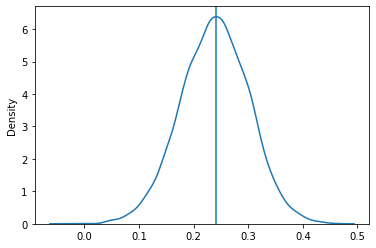

In [7]:
# Quick validation that bootstrapping is valid:
center_div = stats.spearmanr(couples_divergence['bm_fold_original'],
                         couples_divergence['bp_fold_original'])[0]

sns.kdeplot(dist_boot_div)
plt.axvline(x=center_div)

The 95% confidence interval is also computed for the signed divergence correlation:

In this case, a duplicated dataset is used, so that logfold changes are computed in the two possible orientations for each paralog pair

In [8]:
couples_divergence['bm_fold_signed_1'] = np.log2((10**couples_divergence['bm_P1']) / (10**couples_divergence['bm_P2']))
couples_divergence['bp_fold_signed_1'] = np.log2((10**couples_divergence['bp_P1']) / (10**couples_divergence['bp_P2']))
couples_divergence['bm_fold_signed_2'] = np.log2((10**couples_divergence['bm_P2']) / (10**couples_divergence['bm_P1']))
couples_divergence['bp_fold_signed_2'] = np.log2((10**couples_divergence['bp_P2']) / (10**couples_divergence['bp_P1']))

In [9]:
logfold_dupli_1 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2',
                                    'bm_fold_signed_1', 'bp_fold_signed_1']].copy()

logfold_dupli_1.columns = ['Duplication', 'ORF_P1', 'ORF_P2',
                          'bm_fold_signed', 'bp_fold_signed']


logfold_dupli_2 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2',
                                    'bm_fold_signed_2', 'bp_fold_signed_2']].copy()

logfold_dupli_2.columns = ['Duplication', 'ORF_P1', 'ORF_P2',
                          'bm_fold_signed', 'bp_fold_signed']

logfold_dupli = pd.concat([logfold_dupli_1, logfold_dupli_2])

In [10]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(logfold_dupli['bm_fold_signed'],
                      logfold_dupli['bp_fold_signed'])
spearman_ci_sign = (rho_emp[0], rho_emp[1])
dist_boot_sign = rho_emp[2]

In [11]:
spearman_ci_sign

(0.39457477293848486, 0.5417715387001247)

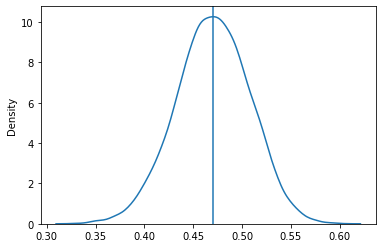

In [12]:
# Quick validation that bootstrapping is valid:
center_sign = stats.spearmanr(logfold_dupli['bm_fold_signed'],
                              logfold_dupli['bp_fold_signed'])[0]

sns.kdeplot(dist_boot_sign)
plt.axvline(x=center_sign)

##2) Preparation of simulation data

Importing the KS stats

In [13]:
dist_comps_1e6 = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Summ_stats_dists/Dist_stats_all_Mut_SD_WGD.csv')
dist_comps_1e5 = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Summ_stats_dists/Dist_stats_all_Mut_SD_WGD_1e5.csv')

Importing the correlations

In [14]:
corrs_1e6 = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Summ_stats_dists/Correlations_all_Mut_SD_WGD.csv')
corrs_1e5 = pd.read_csv('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Summ_stats_dists/Correlations_all_Mut_SD_WGD_1e5.csv')

Reformatting the 'Mut_ratio' column 

In [15]:
# Dictionary of mutational target size ratios
run_ratio = {'0.5': '1/2', '1.0': '1', '2.0': '2', '3.0': '3', '4.0': '4', 
             '5.0': '5', '6.0': '6', '7.0': '7', '8.0': '8', '9.0': '9', 
             '10.0': '10'}
model_convert = {'Mixed': 'Precision-economy', 'No Cost': 'No Cost',
                 'ADS': 'ADS', 'Minimal': 'Minimal'}

In [16]:
dist_comps_1e6 = dist_comps_1e6.astype({'Mut_ratio': 'string'})
dist_comps_1e5 = dist_comps_1e5.astype({'Mut_ratio': 'string'})
corrs_1e6 = corrs_1e6.astype({'Mut_ratio': 'string'})
corrs_1e5 = corrs_1e5.astype({'Mut_ratio': 'string'})

for row in range(dist_comps_1e6.shape[0]):
  dist_comps_1e6.at[row, 'Mut_ratio'] = run_ratio[dist_comps_1e6.at[row, 'Mut_ratio']]
  dist_comps_1e6.at[row, 'Model'] = model_convert[dist_comps_1e6.at[row, 'Model']]

for row in range(dist_comps_1e5.shape[0]):
  dist_comps_1e5.at[row, 'Mut_ratio'] = run_ratio[dist_comps_1e5.at[row, 'Mut_ratio']]
  dist_comps_1e5.at[row, 'Model'] = model_convert[dist_comps_1e5.at[row, 'Model']]

for row in range(corrs_1e6.shape[0]):
  corrs_1e6.at[row, 'Mut_ratio'] = run_ratio[corrs_1e6.at[row, 'Mut_ratio']]
  corrs_1e6.at[row, 'Model'] = model_convert[corrs_1e6.at[row, 'Model']]


for row in range(corrs_1e5.shape[0]):
  corrs_1e5.at[row, 'Mut_ratio'] = run_ratio[corrs_1e5.at[row, 'Mut_ratio']]
  corrs_1e5.at[row, 'Model'] = model_convert[corrs_1e5.at[row, 'Model']]

Computing the mean KS statistics

In [17]:
# Values concerning the distribution of divergence ratios are first dropped
dist_comps_1e6 = dist_comps_1e6[dist_comps_1e6['Property'] != 'Divergence ratio'].reset_index(drop=True)
dist_comps_1e5 = dist_comps_1e5[dist_comps_1e5['Property'] != 'Divergence ratio'].reset_index(drop=True)

In [18]:
KS_means_1e6 = dist_comps_1e6.groupby(by=['Model', 'Mut_sigma', 'Mut_ratio', 'Iter', 'Comparison', 'Type'], as_index=False).mean().copy().reset_index(drop=True)
KS_means_1e6 = KS_means_1e6[['Model', 'Mut_sigma', 'Mut_ratio', 'Comparison', 'Type', 'Moods_stat', 'Moods_p-val', 'KS_stat', 'KS_p-val']]
KS_means_1e5 = dist_comps_1e5.groupby(by=['Model', 'Mut_sigma', 'Mut_ratio', 'Iter', 'Comparison', 'Type'], as_index=False).mean().copy().reset_index(drop=True)
KS_means_1e5 = KS_means_1e5[['Model', 'Mut_sigma', 'Mut_ratio', 'Comparison', 'Type', 'Moods_stat', 'Moods_p-val', 'KS_stat', 'KS_p-val']]

Keeping only the data which is relevant for the figure

In [19]:
KS_1e6_ready = KS_means_1e6[(KS_means_1e6['Model'] != 'ADS') & (KS_means_1e6['Model'] != 'No Cost') & (KS_means_1e6['Comparison'] == 'WGD') & (KS_means_1e6['Type'] == 'All') & (KS_means_1e6['Mut_sigma'] == 0.025)].reset_index(drop=True)
KS_1e5_ready = KS_means_1e5[(KS_means_1e5['Model'] != 'ADS') & (KS_means_1e5['Model'] != 'No Cost') & (KS_means_1e5['Comparison'] == 'WGD') & (KS_means_1e5['Type'] == 'All') & (KS_means_1e5['Mut_sigma'] == 0.075)].reset_index(drop=True)

For the correlations, also keeping only the rows which are relevant for the construction of the figure

In [20]:
corrs_1e6_ready = corrs_1e6[(corrs_1e6['Model'] != 'ADS') & (corrs_1e6['Model'] != 'No Cost') & (corrs_1e6['Type'] == 'All') & (corrs_1e6['Mut_sigma'] == 0.025)].reset_index(drop=True)
corrs_1e5_ready = corrs_1e5[(corrs_1e5['Model'] != 'ADS') & (corrs_1e5['Model'] != 'No Cost') & (corrs_1e5['Type'] == 'All') & (corrs_1e5['Mut_sigma'] == 0.025)].reset_index(drop=True)

##3) Construction of the figure

Dodge and jitter are first added to each dataframe

In [21]:
# Adding new coordinates with dodge and jitter
sym_to_num = {'1/2':1, '1':2, '2':3, '3':4, '4':5, '5':6, '6':7, '7':8,
              '8':9, '9':10, '10':11}

# Adding the 'num' column which will be used
KS_1e6_ready['num'] = np.NaN
KS_1e5_ready['num'] = np.NaN
corrs_1e6_ready['num'] = np.NaN
corrs_1e5_ready['num'] = np.NaN

for row in range(KS_1e6_ready.shape[0]):
  KS_1e6_ready.at[row, 'num'] = sym_to_num[KS_1e6_ready.at[row, 'Mut_ratio']]

for row in range(corrs_1e6_ready.shape[0]):
  corrs_1e6_ready.at[row, 'num'] = sym_to_num[corrs_1e6_ready.at[row, 'Mut_ratio']]

for row in range(KS_1e5_ready.shape[0]):
  KS_1e5_ready.at[row, 'num'] = sym_to_num[KS_1e5_ready.at[row, 'Mut_ratio']]

for row in range(corrs_1e5_ready.shape[0]):
  corrs_1e5_ready.at[row, 'num'] = sym_to_num[corrs_1e5_ready.at[row, 'Mut_ratio']]

# Add dodge
dodge_dict = {'Minimal':0.1875, 'Precision-economy':0.0625}

for row in range(KS_1e6_ready.shape[0]):
  KS_1e6_ready.at[row, 'num'] = KS_1e6_ready.at[row, 'num'] + dodge_dict[KS_1e6_ready.at[row, 'Model']]

for row in range(corrs_1e6_ready.shape[0]):
  corrs_1e6_ready.at[row, 'num'] = corrs_1e6_ready.at[row, 'num'] + dodge_dict[corrs_1e6_ready.at[row, 'Model']]

for row in range(KS_1e5_ready.shape[0]):
  KS_1e5_ready.at[row, 'num'] = KS_1e5_ready.at[row, 'num'] + dodge_dict[KS_1e5_ready.at[row, 'Model']]

for row in range(corrs_1e5_ready.shape[0]):
  corrs_1e5_ready.at[row, 'num'] = corrs_1e5_ready.at[row, 'num'] + dodge_dict[corrs_1e5_ready.at[row, 'Model']]

# Add jitter
def jitter(x):
  return x + np.random.uniform(-0.1, 0.1)

KS_1e6_ready['num'] = KS_1e6_ready['num'].apply(lambda x: jitter(x))
corrs_1e6_ready['num'] = corrs_1e6_ready['num'].apply(lambda x: jitter(x))
KS_1e5_ready['num'] = KS_1e5_ready['num'].apply(lambda x: jitter(x))
corrs_1e5_ready['num'] = corrs_1e5_ready['num'].apply(lambda x: jitter(x))

In [22]:
# A function is defined to plot data with markers and colors for hue-levels
# without using seaborn

def hue_scatter(x, y, data, hue, palette, hue_order, markers, ax, size=None, 
                facecolors=None, alpha=None, linewidths=None):
  # Loop through hue orders and plot the points
  for level in hue_order:
    subset = data[data[hue] == level].copy().reset_index(drop=True)

    if facecolors == 'none':
      ax.scatter(subset[x], subset[y], s=size,
                 marker=markers[level], alpha=alpha, linewidths=linewidths,
                 label=level, facecolors=facecolors, edgecolors=palette[level])
      
    else:
      ax.scatter(subset[x], subset[y], s=size, c=palette[level],
                 marker=markers[level], alpha=alpha, linewidths=linewidths,
                 label=level, facecolors=facecolors)

The final adjustments of the figure as well as the addition of the schematics have been done in Inkscape

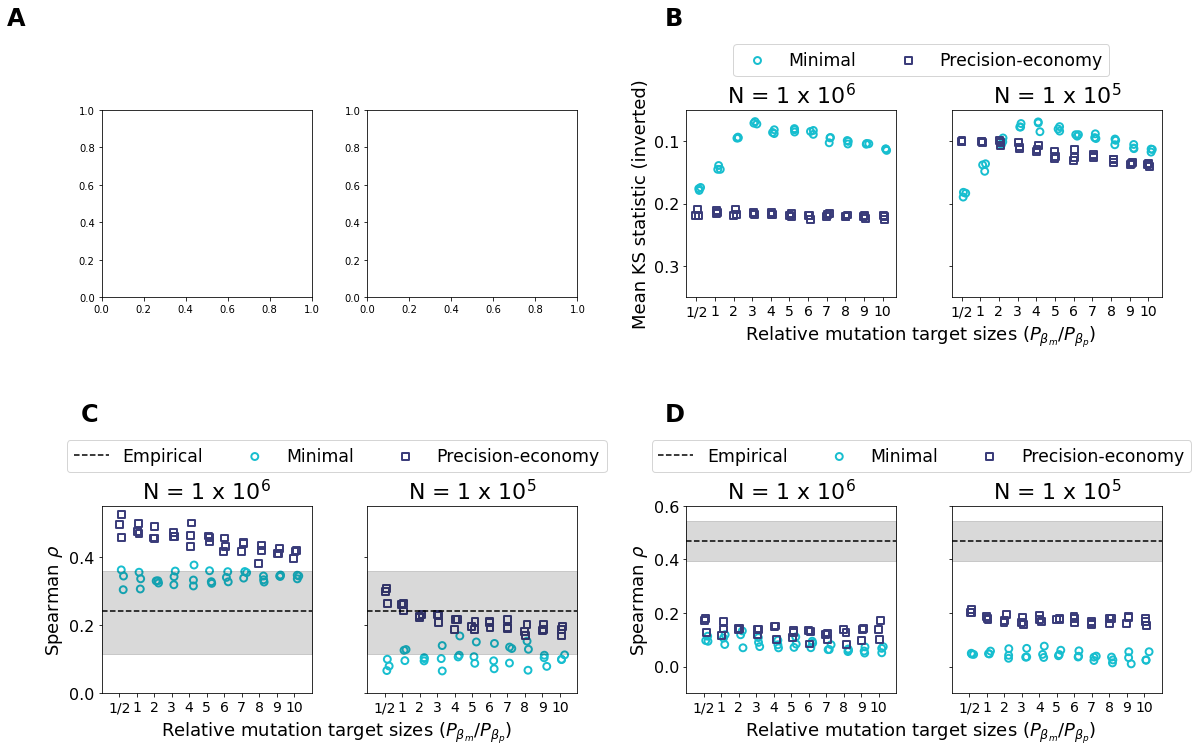

In [23]:
fig = plt.figure(constrained_layout=False, figsize=(18, 10))


# Preparation of the grids
gs1 = fig.add_gridspec(nrows=8, ncols=22, left=0.05, right=0.95, bottom=0.60, 
                       top=0.95, wspace=0.05)
ax1 = fig.add_subplot(gs1[1:7, 1:5])
ax2 = fig.add_subplot(gs1[1:7, 6:10])
ax3 = fig.add_subplot(gs1[1:7, 12:16])
ax4 = fig.add_subplot(gs1[1:7, 17:21])

gs2 = fig.add_gridspec(nrows=8, ncols=22, left=0.05, right=0.95, bottom=0.05, 
                       top=0.40, wspace=0.05)
ax5 = fig.add_subplot(gs2[1:7, 1:5])
ax6 = fig.add_subplot(gs2[1:7, 6:10])
ax7 = fig.add_subplot(gs2[1:7, 12:16])
ax8 = fig.add_subplot(gs2[1:7, 17:21])

# Parameters for the scatterplots
labels = ['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

size = 48

palette = {'Precision-economy': cm.tab20b.colors[0], 'Minimal': cm.tab10.colors[9]}
hue_order = ['Minimal', 'Precision-economy']
markers = {'Precision-economy': 's', 'Minimal':'o'}

facecolors = 'none'

linewidths = 1.95

# Min and Max for KS values
min_KS = 0.050
max_KS = 0.35

# First scatterplot
scatter1 = hue_scatter('num', 'KS_stat', KS_1e6_ready, 'Model', palette,
                       hue_order, markers, ax3, size=size,
                       facecolors=facecolors, linewidths=linewidths)

plt.sca(ax3) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax3.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_KS, top=max_KS)
plt.tick_params(labelsize=16)

plt.gca().invert_yaxis() # Invert y-axis for KS stats

# Second scatterplot
scatter2 = hue_scatter('num', 'KS_stat', KS_1e5_ready, 'Model', palette, 
                       hue_order, markers, ax4, size=size, facecolors=facecolors,
                       linewidths=linewidths)

plt.sca(ax4) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax4.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_KS, top=max_KS)
plt.tick_params(labelsize=16)

plt.gca().invert_yaxis() # Invert y-axis for KS stats

# Min and max for the div correlation
min_div = 0
max_div = 0.55

# Third scatterplot
scatter3 = hue_scatter('num', 'rho_fold', corrs_1e6_ready, 'Model', palette, 
                       hue_order, markers, ax5, size=size, facecolors=facecolors,
                       linewidths=linewidths)
plt.sca(ax5) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax5.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_div, top=max_div)
plt.tick_params(labelsize=16)

# Fourth scatterplot
scatter4 = hue_scatter('num', 'rho_fold', corrs_1e5_ready, 'Model', palette, 
                       hue_order, markers, ax6, size=size, facecolors=facecolors,
                       linewidths=linewidths)
plt.sca(ax6) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax6.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_div, top=max_div)
plt.tick_params(labelsize=16)

# Addition of the empirical correlation + 95% CI to scatters of correlation
for ax in [ax5, ax6]:
  ax.set_xlim(left=0, right=12)
  x_lims = ax.get_xlim()
  ax.axhline(y=center_div, c='k', linestyle='--', label='Empirical')
  ax.fill_between(x_lims, spearman_ci_div[0], spearman_ci_div[1], 
                  color='black', alpha=0.15)
  
# Min and max for the signed div correlation
min_sign = -0.1
max_sign = 0.60

# Fifth scatterplot
scatter5 = hue_scatter('num', 'rho_signed', corrs_1e6_ready, 'Model', palette, 
                       hue_order, markers, ax7, size=size, 
                       facecolors=facecolors, linewidths=linewidths)

plt.sca(ax7) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax7.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_sign, top=max_sign)
plt.tick_params(labelsize=16)

# Sixth scatterplot
scatter7 = hue_scatter('num', 'rho_signed', corrs_1e5_ready, 'Model', palette, 
                       hue_order, markers, ax8, size=size, 
                       facecolors=facecolors, linewidths=linewidths)

plt.sca(ax8) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax8.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_sign, top=max_sign)
plt.tick_params(labelsize=16)

# Addition of the empirical correlation + 95% CI to scatters of correlation
for ax in [ax7, ax8]:
  ax.set_xlim(left=0, right=12)
  x_lims = ax.get_xlim()
  ax.axhline(y=center_sign, c='k', linestyle='--', label='Empirical')
  ax.fill_between(x_lims, spearman_ci_sign[0], spearman_ci_sign[1], 
                  color='black', alpha=0.15)

# Removing useless ytick labels
for ax in [ax4, ax6, ax8]:
  ax.set_ylabel('')
  ax.tick_params(labelleft=False)

# Legends and labels
ax3.legend(bbox_to_anchor=(1.12, 1.35), loc=9, borderaxespad=0,
                 fontsize='xx-large', ncol=2)

ax5.legend(bbox_to_anchor=(1.12, 1.35), loc=9, borderaxespad=0,
                 fontsize='xx-large', ncol=3)

ax7.legend(bbox_to_anchor=(1.12, 1.35), loc=9, borderaxespad=0,
                 fontsize='xx-large', ncol=3)

ax3.set_ylabel(r"Mean KS statistic (inverted)", fontsize=18)
ax5.set_ylabel(r"Spearman $\rho$", fontsize=18)
ax7.set_ylabel(r"Spearman $\rho$", fontsize=18)

# Manual addition of xlabels
ax3.annotate(r"Relative mutation target sizes ($P_{\beta_m}$/$P_{\beta_p}$)",
             (0.28, -0.225), xycoords='axes fraction', fontsize=18)
ax5.annotate(r"Relative mutation target sizes ($P_{\beta_m}$/$P_{\beta_p}$)",
             (0.28, -0.225), xycoords='axes fraction', fontsize=18)
ax7.annotate(r"Relative mutation target sizes ($P_{\beta_m}$/$P_{\beta_p}$)",
             (0.28, -0.225), xycoords='axes fraction', fontsize=18)

# Manual setting of xtick labels size
for ax in [ax3, ax4, ax5, ax6, ax7, ax8]:
  ax.tick_params(axis='x', which='major', labelsize=14)

ax3.set_title(r"N = 1 x $10^6$", fontsize=22)
ax4.set_title(r"N = 1 x $10^5$", fontsize=22)
ax5.set_title(r"N = 1 x $10^6$", fontsize=22)
ax6.set_title(r"N = 1 x $10^5$", fontsize=22)
ax7.set_title(r"N = 1 x $10^6$", fontsize=22)
ax8.set_title(r"N = 1 x $10^5$", fontsize=22)

ax1.annotate('A', (-0.45, 1.45), xycoords='axes fraction', fontsize=24, 
             fontweight='bold')
ax3.annotate('B', (-0.1, 1.45), xycoords='axes fraction', fontsize=24, 
             fontweight='bold')
ax5.annotate('C', (-0.1, 1.45), xycoords='axes fraction', fontsize=24, 
             fontweight='bold')
ax7.annotate('D', (-0.1, 1.45), xycoords='axes fraction', fontsize=24, 
             fontweight='bold')

# Saving the figure
Fig4 = plt.gcf()
#Fig4.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/'
              #'Fig4_py.tiff', bbox_inches='tight')
Fig4.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/'
              'Fig4_py.svg', bbox_inches='tight')